In [1]:
from shfl.data_base.emnist import Emnist

database = Emnist()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(type(train_data[0]))
train_data[0].shape

Using TensorFlow backend.


200000
40000
40000
<class 'numpy.ndarray'>


(28, 28)

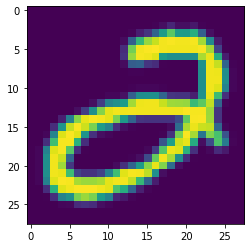

In [2]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0])

In [3]:
import shfl
import numpy as np

class NumberOfInstances(shfl.private.FederatedTransformation):
        
    def apply(self, labeled_data):
        print(len(labeled_data.label))
        
        
class UniqueLabels(shfl.private.FederatedTransformation):
        
    def apply(self, labeled_data):
        classes = [label.argmax(-1) for label in labeled_data.label]
        print(np.unique(classes))
        

# I.I.D. Federated Sampling

In the IID scenario, each node has independent and identically distributed access to all observations in the dataset.

The only available choices are:
1. Percentage of the dataset used.
2. Number of instances per node.
3. Sampling with or without replacement.


## Percentage of the dataset used in a i.i.d scenario

The *percent* parameter indicates the percentage of the total number of observation in the datased splitted across the different clients. Since the subset is chosen randomly, it statistically becomes representative and follows the same distribution that the whole dataset. Obviously, it **can not be** neither greated than 100 or lesser than 0.


## Number of instances per node in a i.i.d scenario

The *weight* parameter indicates the deterministic distribution of the number of samples per node, as a ratio over the total number of observations in the dataset used for the simulation. For instance, *weights = [0.2, 0.3, 0.5]* means that the first node will be assigned a 20% of the total number of observations in the dataset used, the second node a 30% and the third node a 50%. 

Note that the *weight* parameter must not necessarily sum up to one, because of the option of *sampling*. We specify this fact below.


## Sampling with or without replacement

The *sampling* parameter, which can have one of the following two values *'with_replacement'* or *'without_replacement'*, indicates if an observation assigned to a particular node is removed from the dataset pool and thereof, it will be assigned only once (*weight = 'without_replacement'*); or will be back to the dataset pool and thereof, it could be selected for a new asignation (*weight = 'with_replacement'*).

## Combinations of the *weights* and *sampling* parameters

### *sampling = 'without_replacement'* 

When *sampling = 'without_replacement'* the total number of samples assigned to the nodes **can not be** greater than the number of available observations in the dataset. This imposes the constraint on the *weights* parameter than the sum of the *weights* values should be equal to one. If they are not, the weights will be normalised to sum 1.  The possible cases are:

1. If the sum of the *weights* values is equal to one when *sampling = 'without_replacement'* then, the resulting distribution of observations to the nodes (the union of the nodes sets of samples) is eaxactly the raw dataset, that is, the distributed samples conform a partition of the original dataset.

In [4]:
from shfl.data_distribution.data_distribution_iid import IidDataDistribution

iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.3,0.3,0.4])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
36000
36000
48000


2. If the sum of the *weights* values is greater or lesser than one when *sampling = 'without_replacement'* then, the *weights* values will be normalised to sum up to one. For instance, giving *sampling = 'without_replacement'* and *weights = [0.2, 0.3, 0.7]* the sum of the *weights* values is 1.2 > 1, and thereof, the effective *weights* values will result of the normalization: *weights = [0.2/1.2, 0.3/1.2, 0.7/1.2]*.

In [5]:
iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.2,0.3,0.7])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
20000
30000
70000


### *sampling = 'with_replacement'* 

When *sampling = 'with_replacement'* the total number of samples assigned to the nodes **can be** greater or lesser than the number of available observations in the dataset. This removes any constraint on the *weights* parameter values. The resulting distribution of samples across the nodes are subsets of the original dataset that could share observations and also, each node could have none, one or more than one samples of a given observation.

In [6]:
iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.2,0.3,0.7], 
                                                                            sampling = "with_replacement")

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
24000
36000
84000


# Non-I.I.D. Federated Sampling

In the non-IID scenario, each node has not independent or identically distributed access to all observations in the dataset. 

The only available choices are:
1. Percentage of the dataset used.
2. Number of instances per node.

The *percentage* and *weights* have the same functionality as in the I.I.D federated sampling. 

According to the *sampling* parameter, in this case it will always be *sampling = 'with_replacement'* because otherwise, due to non-I.I.D restrictions (clients with reduced number of known labels), there is no way to ensure that there will be enough data to distribute among the clients. Hence, *weights* parameter should always sum up to 1. Otherwise, it will be normalised to sum up 1.

In [7]:
from shfl.data_distribution.data_distribution_non_iid import NonIidDataDistribution

non_iid_distribution = NonIidDataDistribution(database)
federated_data, test_data, test_label = non_iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.2,0.3,0.7])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
20000
30000
70000


The particularity of this type of federated sampling is the distribution of labels among clients. For each client, we randomly choose the number of labels it knows and which ones they are. We show the labels known by each client.

In [8]:
print("Known labels per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, UniqueLabels())

Known labels per client:
[4 8]
[1 3 4 5 8 9]
[0 2 3 6 7 9]
